# Customer Credit Scorecard Development
##### - An example using German Credit Data and Logistic Regression

_Author_: QH  
_First Version Date: 2022-12-09_  
_Latest update on: 2023-01-05_

## Data Dictionary of German Credit Data
The following is the data dictionary for this dataset. Some of the variables have been label encoded (i.e. ordinal encoded):

| Variable Name | Description | Values|Type|
| :--|:-- | :-- |:--|
|`Creditability`|Credit-worthiness of a client|1: credit-worthy <br> 0: not credit-worth|Target Variable|
|`Account Balance`|Balance of current account|1: no running account <br> 2: no balance or debit <br> 3: 0 <= ... < 200 DM <br> 4: ... >= 200 DM or checking account for at least 1 year|Ordinal|
|`Duration of Credit (month)`|Duration in months (metric)|-|Numeric|
|`Payment Status of Previous Credit`|Payment of previous credits|0：hesitant payment of previous credits <br> 1:problematic running account / there are further credits running but at other banks <br> 2: no previous credits / paid back all previous credits <br> 3:no problems with current credits at this bank <br> 4:paid back previous credits at this bank|Nominal|
|`Purpose`|Purpose of Credit|0:other <br> 1:new car <br> 2:used car <br> 3:items of furniture <br> 4:radio / television <br> 5:household appliances <br> 6:repair <br> 7:education <br> 8:vacation <br> 9:retraining <br> 10:business|Nominal|
|`Credit Amount`|Amount of credit|-|Numeric|
|`Value Savings/Stocks`|Value of savings or stocks|1:not available / no savings <br> 2: < 100 DM <br> 3: 100 <= ... < 500 - DM <br> 4:500 <= ... < 1000 DM <br> 5: >= 1000 DM|Ordinal|
|`Length of current employment`|Has been employed by current employer for|1: unemployed <br> 2: <= 1 year <br> 3: 1 <= ... < 4 years <br> 4: 4 <= ... < 7 years <br> 5: >= 7 years|Ordinal|
|`Instalment per cent`|Instalment in % of available income|1:>= 35 <br> 2: 25 <= ... < 35 <br> 3:20 <= ... < 25 <br> 4: < 20 |Ordinal|
|`Sex & Marital Status`|Marital Status/Sex|1: male: divorced / living apart <br> 2: male: single <br> 3: male: married / widowed <br> 4: female|Nominal|
|`Guarantors`|Further debtors / Guarantors|1: none <br> 2: Co-Applicant <br> 3: Guarantor|Ordinal|
|`Duration in Current address`|Living in current household for|1: < 1 year <br> 2: 1 <= ... < 4 years <br> 3: 4 <= ... < 7 years <br> 4: >= 7 years|Ordinal|
|`Most valuable available asset`|Most valuable available assets|1: not available / no assets <br> 2: Car / Other <br> 3: Savings contract with a building society / Life insurance <br> 4: Ownership of house or land|Nominal/Ordinal|
|`Age (years)`|Age in years|-|Numeric|
|`Concurrent Credits`|Further running credits|1: at other banks <br> 2: at department store or mail order house <br> 3: no further running credits|Nominal/Ordinal|
|`Type of apartment`|Type of apartment|1: rented flat <br> 2: owner-occupied flat <br> 3: free apartment|Nominal/Ordinal|
|`No of Credits at this Bank`|Number of previous credits at this bank including the running one|1: one <br> 2: two or three <br> 3: four or five <br> 4: six or more|Ordinal|
|`Occupation`|Occupation|1: unemployed / unskilled with no permanent residence <br> 2: unskilled with permanent residence <br> 3: skilled worker / skilled employee / minor civil servant <br> 4: executive / self-employed / higher civil servant|Nominal/Ordinal|
|`No of dependents`|Number of persons entitled to maintenance|1: 0 - 2 <br> 2: 3 and more |Ordinal|
|`Telephone`|Whether he/she has a telephone?|1: no <br> 2: yes|Nominal|
|`Foreign Worker`|Whether he/she is a foreign worker?|1: yes <br> 2:no|Nominal|

## 2. Python and Library Versions

Import the packages needed for the analysis and print out the versions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
import scipy
import optbinning as optbin
import tabulate
import statsmodels

from matplotlib import pyplot as plt
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# import utility functions
import sys
import os
# setting path
sys.path.append('..')
from py_util import util, preprocessing_util as prep, perfcheck_util as perfc

In [2]:
print('Python version: ' + sys.version)
package_dict = {'Pandas': pd, 'Numpy': np, 'Matplotlib': matplotlib, 'Seaborn': sns, 
'Scikit-Learn': sklearn, 'SciPy': scipy, 'Optimal Binning': optbin, "tabulate": tabulate, 'statsmodels': statsmodels}
util.print_version(package_dict)

Python version: 3.9.4 (v3.9.4:1f2e3088f3, Apr  4 2021, 12:32:44) 
[Clang 6.0 (clang-600.0.57)]
Pandas: 1.4.3
Numpy: 1.23.2
Matplotlib: 3.5.3
Seaborn: 0.11.2
Scikit-Learn: 1.1.2
SciPy: 1.9.0
Optimal Binning: 0.17.2
tabulate: 0.8.10
statsmodels: 0.13.2


## 3. Exploratory Analysis

First, we read in the dataset.

In [3]:
# read-in dataset
german_credit_ds = pd.read_csv("german_credit.csv")

Get the data information. As can be seen from the following there are in total 1000 observations and 21 columns with no missing data.

In [4]:
german_credit_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

In [5]:
# Take a look at the data
german_credit_ds.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


### 3.1 Univariate Analysis - Binning and Initial Evaluation

In this section we will 
* Group all the attributes into different risk categories.
* Separate numeric variable and categorical variable, And then we will do binning/grouping for numeric variables and regrouping for categorical variables if some groups have small sample sizes.  
* Calculate the WOE and IV for each features and rank order them within each risk category.

First, we will group these features into different risk categories.

* __Financial Strength__:
    * Account Balance
    * Value Savings/Stocks
    * Guarantors
    * Most valueable available asset
    * Type of apartment
* __Current Credit Application Information__:
    * Credit Amount
    * Purpose
* __Credit History__:
    * Duration of Credit (month)
    * Installment per cent
    * Payment Status of Previous Credit
    * Concurrent Credits
    * No of Credits at this Bank
* __Financial Stability__:
    * Length of current employement
    * Duration in Current address
    * Occupation
    * Foreign Worker
* __Demographics__:
    * Sex & Marital Status
    * Age (years)
    * Telephone
    * No of dependents

Using the above categorization, we can create a mapping dictionary as follows:

In [6]:
risk_category = {
    'Account Balance' : 'Financial Strength',
    'Duration of Credit (month)': 'Credit History',
    'Payment Status of Previous Credit': 'Credit History', 
    'Purpose': 'Current Credit Info', 
    'Credit Amount': 'Current Credit Info',
    'Value Savings/Stocks': 'Financial Strength', 
    'Length of current employment': 'Financial Stability',
    'Instalment per cent': 'Credit History', 
    'Sex & Marital Status': 'Demographics', 
    'Guarantors': 'Financial Strength',
    'Duration in Current address': 'Financial Stability', 
    'Most valuable available asset': 'Financial Strength',
    'Age (years)': 'Demographics', 
    'Concurrent Credits': 'Credit History', 
    'Type of apartment': 'Financial Strength',
    'No of Credits at this Bank': 'Credit History', 
    'Occupation': 'Financial Stability', 
    'No of dependents': 'Demographics',
    'Telephone': 'Demographics', 
    'Foreign Worker': 'Financial Stability'
}

And then we separate the features into numeric and categorical variables as following shows:

In [7]:
# Columns of the data: Creditability is the target variable (if there's more than 10 unique values in a feature, we treat as numeric variables)
variables = prep.split_num_cat_target(german_credit_ds, 'Creditability', lvl_theta=10, show=True)

╒═════════════╤════════════════════════════════════════════════════════════════════════╕
│ Type        │ Variables Names                                                        │
╞═════════════╪════════════════════════════════════════════════════════════════════════╡
│ Target      │ Creditability                                                          │
├─────────────┼────────────────────────────────────────────────────────────────────────┤
│ ID          │                                                                        │
├─────────────┼────────────────────────────────────────────────────────────────────────┤
│ Numeric     │ Duration of Credit (month), Credit Amount, Age (years)                 │
├─────────────┼────────────────────────────────────────────────────────────────────────┤
│ Categorical │ Account Balance, Payment Status of Previous Credit, Purpose, Value     │
│             │ Savings/Stocks, Length of current employment, Instalment per cent, Sex │
│             │ & Mar

Now we using `optbinning` python library to group the numeric and categorical variables to generate the best information value.

In [8]:
y = german_credit_ds['Creditability'].values

binning_decision = {'var_type':[],'variable':[], 'splits':[], 'total_iv':[], 'optbin_table':[]}
for variable in variables['numeric']:
    print("###################################################################")
    print(f"Numeric Variable: {variable}")
    x = german_credit_ds[variable].values
    optb = optbin.OptimalBinning(name=variable, dtype='numerical', solver='mip')
    optb.fit(x, y)
    print(optb.status)
    print(f"Optimal Split: {optb.splits}")
    binning_table = optb.binning_table.build()
    #print(tabulate.tabulate(binning_table, headers="keys"))
    binning_decision['var_type'].append('numeric')
    binning_decision['variable'].append(variable)
    binning_decision['splits'].append(optb.splits)
    binning_decision['total_iv'].append(binning_table.loc['Totals', 'IV'])
    print(f"Total IV: {binning_table.loc['Totals', 'IV']}")
    binning_decision['optbin_table'].append(binning_table)

for variable in variables['categorical']:
    print("###################################################################")
    print(f"Categorical Variable: {variable}")
    x = german_credit_ds[variable].values
    optb = optbin.OptimalBinning(name=variable, dtype='categorical', solver='mip', cat_cutoff=0.1)
    optb.fit(x, y)
    print(optb.status)
    print(f"Optimal Split: {optb.splits}")
    binning_table = optb.binning_table.build()
    #print(tabulate.tabulate(binning_table, headers="keys"))
    binning_decision['var_type'].append('categorical')
    binning_decision['variable'].append(variable)
    binning_decision['splits'].append(optb.splits)
    binning_decision['total_iv'].append(binning_table.loc['Totals', 'IV'])
    print(f"Total_IV: {binning_table.loc['Totals', 'IV']}")
    binning_decision['optbin_table'].append(binning_table)

###################################################################
Numeric Variable: Duration of Credit (month)
OPTIMAL
Optimal Split: [ 8.5 11.5 15.5 26.5 34.5 43.5]
Total IV: 0.2889771769184098
###################################################################
Numeric Variable: Credit Amount
OPTIMAL
Optimal Split: [ 959.5 1373.  3446.5 3909.5 6322.5 7839.5]
Total IV: 0.24207735158237664
###################################################################
Numeric Variable: Age (years)
OPTIMAL
Optimal Split: [23.5 25.5 29.5 34.5]
Total IV: 0.10328602001184728
###################################################################
Categorical Variable: Account Balance
OPTIMAL
Optimal Split: [array([1]), array([2]), array([4]), array([3])]
Total_IV: 0.6660115033513336
###################################################################
Categorical Variable: Payment Status of Previous Credit
OPTIMAL
Optimal Split: [array([2]), array([4]), array([3, 1, 0])]
Total_IV: 0.22662562493424002
######

In [9]:
initial_bin_summary = pd.DataFrame(binning_decision)
initial_bin_summary['risk_category'] = initial_bin_summary['variable'].map(risk_category)
initial_bin_summary = initial_bin_summary.sort_values(by=['risk_category', 'total_iv'], ascending=False)
# if the total iv_value < 0.02, mark as removed for the initial assessment
initial_bin_summary['init_rmv_ind'] = initial_bin_summary['total_iv'] < 0.02
initial_bin_summary.drop(columns=["optbin_table"])

,var_type,variable,splits,total_iv,risk_category,init_rmv_ind
3,categorical,Account Balance,"[[1], [2], [4], [3]]",0.666012,Financial Strength,False
6,categorical,Value Savings/Stocks,"[[1], [2], [5], [3, 4]]",0.192473,Financial Strength,False
12,categorical,Most valuable available asset,"[[4], [3], [2], [1]]",0.112638,Financial Strength,False
14,categorical,Type of apartment,"[[3], [1], [2]]",0.085393,Financial Strength,False
10,categorical,Guarantors,"[[1], [3, 2]]",0.000003,Financial Strength,True
7,categorical,Length of current employment,"[[2], [3], [5], [4], [1]]",0.086434,Financial Stability,False
19,categorical,Foreign Worker,"[[1], [2]]",0.043877,Financial Stability,False
16,categorical,Occupation,"[[4], [3], [2], [1]]",0.008763,Financial Stability,True
11,categorical,Duration in Current address,"[[2], [4], [3], [1]]",0.003589,Financial Stability,True
2,numeric,Age (years),"[23.5, 25.5, 29.5, 34.5]",0.103286,Demographics,False


Next step, we will evaluate whether the grouping is logical and making business sense and make adjustment. We will plot the woe against the groups using the following helper function:

In [10]:
def woe_iv_calc(df, bin_var, target, plot=False, as_subplot=False):
    _df_temp = df.groupby(by=bin_var, as_index=False)[target].value_counts()
    _df_temp = _df_temp.pivot(index=bin_var, columns=target, values='count').reset_index()
    event_total = _df_temp[1].sum()
    non_event_total = _df_temp[0].sum()
    _df_temp['event_distr'] = _df_temp[1] / event_total
    _df_temp['non_event_distr'] = _df_temp[0]/ non_event_total
    _df_temp['woe'] = np.log(_df_temp['event_distr'] / _df_temp['non_event_distr'])
    _df_temp['iv'] = (_df_temp['event_distr'] - _df_temp['non_event_distr']) * _df_temp['woe']
    _df_temp['index'] = _df_temp.index.values
    print(f"Information Value for the Feature is: {_df_temp['iv'].sum()}")
    if plot==True:
        if as_subplot==False:
            fig = plt.figure(figsize = (4, 3))
        ax1 = sns.lineplot(data=_df_temp, x='index', y='woe')
        sns.pointplot(data=_df_temp, x='index', y='woe')
        ax2 = ax1.twinx()
        _df_temp[[0,1]].plot(kind='bar', stacked=True, ax=ax2, alpha=0.3)
        ax2.legend(labels=[f'Non-{target}', f'{target}'], loc = 'upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)
        ax1.set_xlabel('Bin')
        ax2.set_ylabel('count')
        x_labels = _df_temp[bin_var].values.astype(str)
        ax1.set_xticks(range(len(x_labels)))
        ax1.set_xticklabels(x_labels, rotation=30)
        ax1.tick_params(axis='x', which='major', labelsize=8)
        plt.rcParams['axes.titlepad'] = 30
        ax1.set_title(f"{bin_var} - iv: {round(_df_temp['iv'].sum(), 4)}")
        if as_subplot==False:
            plt.show()
    # Calculate the mapping from group to woe
    woe_mapping = {}
    for index, row in _df_temp.iterrows():
        woe_mapping[row[bin_var]] = row['woe']
    return _df_temp, woe_mapping

#### Financial Strength
* Account Balance  
    * We will use the current grouping from the data set. And the woe is logical since the higher the balance, the higher the woe.

Information Value for the Feature is: 0.6660115033513336


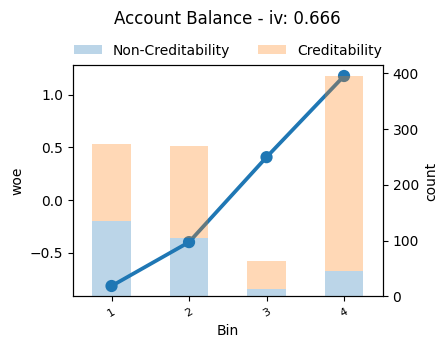

In [11]:
plot_table, account_balance_woe_mapping  = woe_iv_calc(german_credit_ds, 'Account Balance', 'Creditability', plot=True, as_subplot=False)

* Value Savings/Stocks
    * Combine 1, 2 to be 1: "< 100DM"
    * Set others to be category - 1

Information Value for the Feature is: 0.19600955690422672


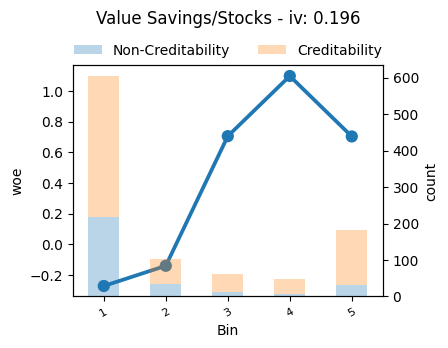

In [12]:

plot_table, value_savings_woe_mapping = woe_iv_calc(german_credit_ds, 'Value Savings/Stocks', 'Creditability', plot=True)

* Most valuable available asset
    * The optimal binning generate similar woe for group 2 and 3. We will do the following re-binning:
        * Combine 2, 3 to be 2: "car, life insurance or other"
        * Change 4 to be 3: "Ownership of house or land"

Information Value for the Feature is: 0.11263826240979674
Information Value for the Feature is: 0.11263392528503957


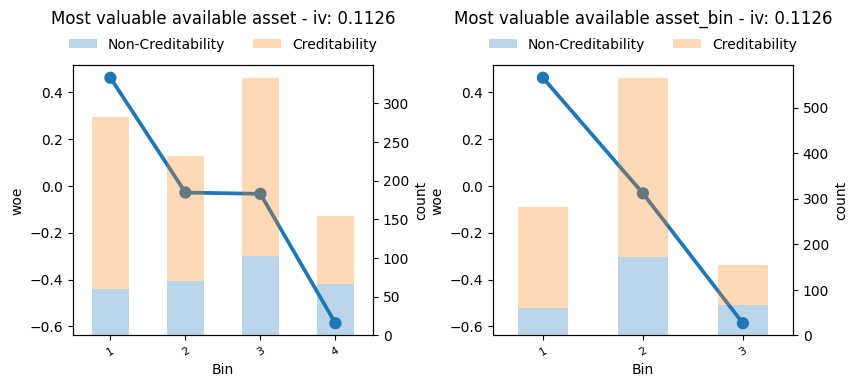

In [13]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Most valuable available asset', 'Creditability', plot=True, as_subplot=True)
mapping = {1: 1, 2: 2, 3: 2, 4: 3}
german_credit_ds['Most valuable available asset_bin'] = german_credit_ds['Most valuable available asset'].map(mapping)
plt.subplot(1,2,2)
plot_table, valuable_asset_woe_mapping = woe_iv_calc(german_credit_ds, 'Most valuable available asset_bin', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Type of apartment:
    * Since group 1 and 3 generate similar woe and makes business sense, because if borrower rents for free highly likely they do not have enough money to pay for rent and then ask relatives to provide free residence. So we will do the following to re-group:
        * Combine 1, 3 to be 1: "Non-owner occupied: rented or free
        * 2 to 2: 'Owner-occupied'

Information Value for the Feature is: 0.08539292555448515
Information Value for the Feature is: 0.08487576666852238


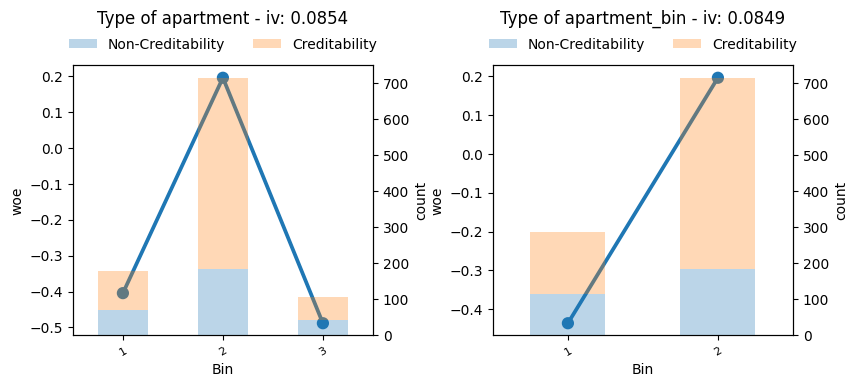

In [14]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table,_ = woe_iv_calc(german_credit_ds, 'Type of apartment', 'Creditability', plot=True, as_subplot=True)
mapping = {1: 1, 2: 2, 3: 1}
german_credit_ds['Type of apartment_bin'] = german_credit_ds['Type of apartment'].map(mapping)
plt.subplot(1,2,2)
plot_table, apartment_woe_mapping = woe_iv_calc(german_credit_ds, 'Type of apartment_bin', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Financial Stability
    * Length of current employment:
        * combine 1, 2 to be 1: "< 1 year or unemployed
        * set others to be category - 1

Information Value for the Feature is: 0.086433631026641
Information Value for the Feature is: 0.0853013783927199


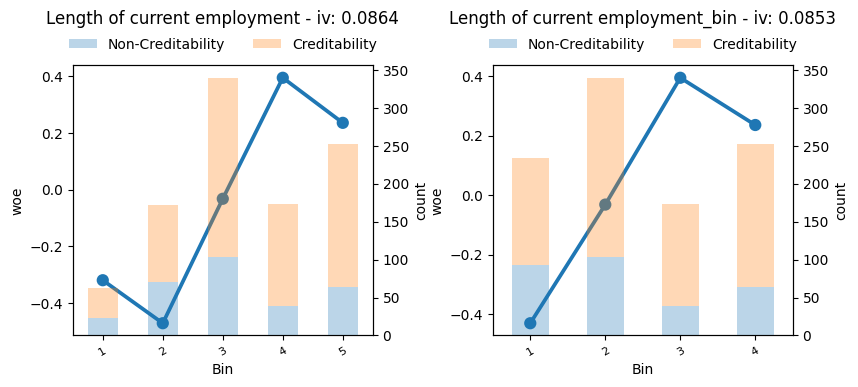

In [15]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Length of current employment', 'Creditability', plot=True, as_subplot=True)
mapping = {1: 1, 2: 1, 3: 2, 4: 3, 5: 4}
german_credit_ds['Length of current employment_bin'] = german_credit_ds['Length of current employment'].map(mapping)
plt.subplot(1,2,2)
plot_table, length_employment_woe_mapping = woe_iv_calc(german_credit_ds, 'Length of current employment_bin', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

Information Value for the Feature is: 0.04387741201028899


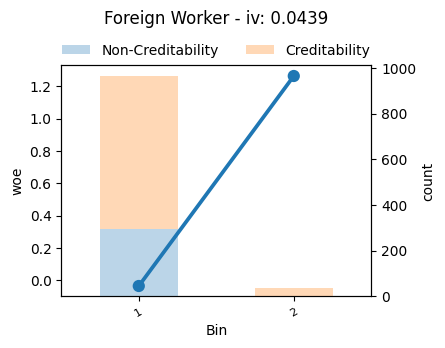

In [16]:
plot_table, foreign_worker_woe_mapping = woe_iv_calc(german_credit_ds, 'Foreign Worker', 'Creditability', plot=True)

* Demographics
    * Age. We use the optimal binning. It is more logical to see the higher the age the more creditworthiness because of financial capability increases as age increases. So we did a re-group to combine similar woe groups.

Information Value for the Feature is: 0.10328602001184728
Information Value for the Feature is: 0.10115938771599864


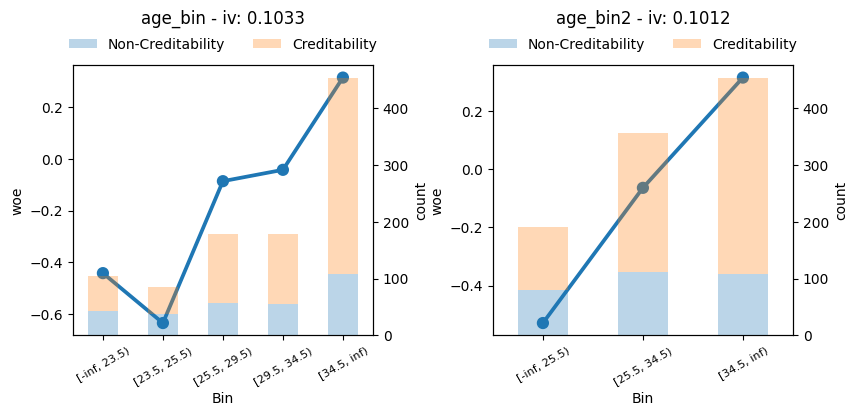

In [17]:
split = initial_bin_summary.loc[initial_bin_summary['variable'] == 'Age (years)', 'splits'].values[0].tolist()
splits = [-np.inf]
splits.extend(split)
splits.extend([np.inf])
german_credit_ds['age_bin'] = pd.cut(german_credit_ds['Age (years)'], splits, right=False)
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'age_bin', 'Creditability', plot=True, as_subplot=True)
splits_2 = [-np.inf, 25.5, 34.5, np.inf]
german_credit_ds['age_bin2'] = pd.cut(german_credit_ds['Age (years)'], splits_2, right=False)
plt.subplot(1,2,2)
plot_table, age_woe_mapping = woe_iv_calc(german_credit_ds, 'age_bin2', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Sex & Marital Status:
    * Combine 3, 4 to be 3: " Married Male and Female regardless of marriage

Information Value for the Feature is: 0.04467067763379073
Information Value for the Feature is: 0.044614692842839435


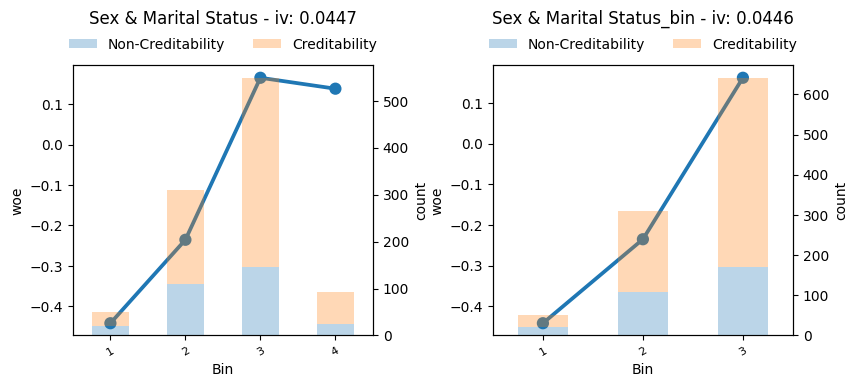

In [18]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Sex & Marital Status', 'Creditability', plot=True, as_subplot=True)
mapping = {1:1, 2:2, 3:3, 4:3}
german_credit_ds['Sex & Marital Status_bin'] = german_credit_ds['Sex & Marital Status'].map(mapping)
plt.subplot(1,2,2)
plot_table, sex_marital_woe_mapping = woe_iv_calc(german_credit_ds, 'Sex & Marital Status_bin', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Current Credit Information
    * Credit amount. We leverage the optimal binning and combine the groups with similar woe. It is interesting to see that as credit amount increases, the credit-worthiness increases since the ability to afford larger credit increases. However, if the amount increases too much, it will decrease the credit-worthiness.

Information Value for the Feature is: 0.24207735158237664
Information Value for the Feature is: 0.24206292083472847


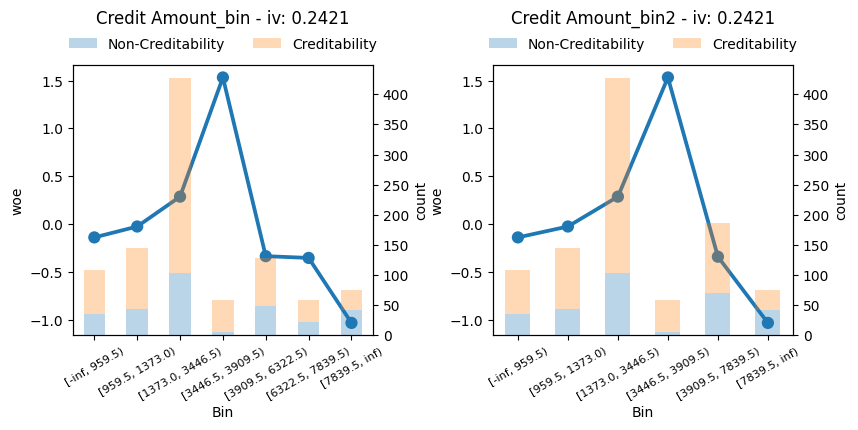

In [19]:
split = initial_bin_summary.loc[initial_bin_summary['variable'] == 'Credit Amount', 'splits'].values[0].tolist()
splits = [-np.inf]
splits.extend(split)
splits.extend([np.inf])
german_credit_ds['Credit Amount_bin'] = pd.cut(german_credit_ds['Credit Amount'], splits, right=False)
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Credit Amount_bin', 'Creditability', plot=True, as_subplot=True)
splits_2 = [-np.inf, 959.5, 1373, 3446.5, 3909.5, 7839.5, np.inf]
german_credit_ds['Credit Amount_bin2'] = pd.cut(german_credit_ds['Credit Amount'], splits_2, right=False)
plt.subplot(1,2,2)
plot_table, credit_amount_woe_mapping = woe_iv_calc(german_credit_ds, 'Credit Amount_bin2', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Purpose 
    * Combine 4, 5, 6 to be 4 as "TV or appliances and maintenance"
    * Combine 7, 8, 9, 10 to be 5 as "Education or Business"

Information Value for the Feature is: 0.14712042845678353
Information Value for the Feature is: 0.15129608723103835


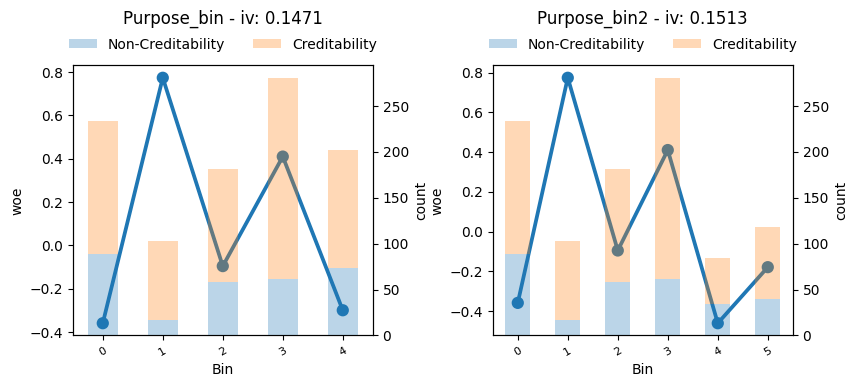

In [20]:
mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 7:4, 8:4, 9:4, 10:4}
german_credit_ds['Purpose_bin'] = german_credit_ds['Purpose'].map(mapping)
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Purpose_bin', 'Creditability', plot=True, as_subplot=True)

mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:4, 6:4, 7:5, 8:5, 9:5, 10:5}
german_credit_ds['Purpose_bin2'] = german_credit_ds['Purpose'].map(mapping)
plt.subplot(1,2,2)
plot_table, purpose_woe_mapping = woe_iv_calc(german_credit_ds, 'Purpose_bin2', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Credit History
    * Curation of Credit (month). We are using the optimal binning. The longer the credit, the more likely that it will become bad.

Information Value for the Feature is: 0.2889771769184098


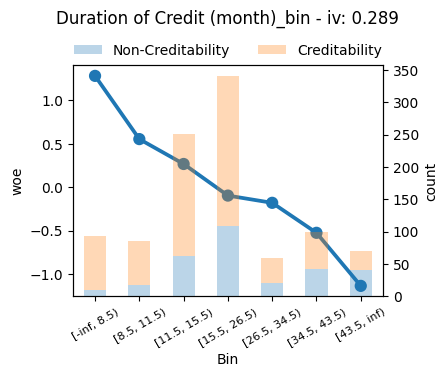

In [21]:
split = initial_bin_summary.loc[initial_bin_summary['variable'] == 'Duration of Credit (month)', 'splits'].values[0].tolist()
splits = [-np.inf]
splits.extend(split)
splits.extend([np.inf])
german_credit_ds['Duration of Credit (month)_bin'] = pd.cut(german_credit_ds['Duration of Credit (month)'], splits, right=False)
plot_table, duration_credit_woe_mapping = woe_iv_calc(german_credit_ds, 'Duration of Credit (month)_bin', 'Creditability', plot=True)

* Payment Status of Previous Credit:
    * Combine 0, 1 to be 1: "Problematic of paying previous credits or problematic running account"
    * Combine 2, 3 to be 2: "No issues on the previous and current credits
    * Set 4 to be 3: "Paid back previous credit at this bank" 

Information Value for the Feature is: 0.2918290877359534


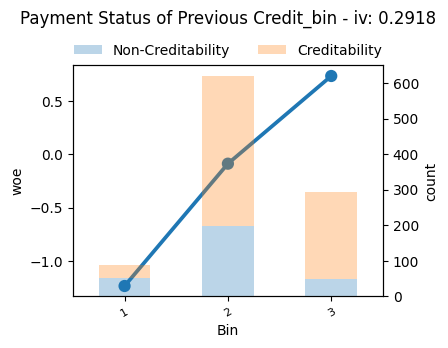

In [22]:
mapping = {0:1, 1:1, 2:2, 3:2, 4:3}
german_credit_ds['Payment Status of Previous Credit_bin'] = german_credit_ds['Payment Status of Previous Credit'].map(mapping)
plot_table, payment_status_woe_mapping = woe_iv_calc(german_credit_ds, 'Payment Status of Previous Credit_bin', 'Creditability', plot=True)

* Concurrent credits:
    * combine 1, 2 to be 1: "There are concurrent credits"
    * set 3 to be 2: "No further running credits"

Information Value for the Feature is: 0.057614541955647885
Information Value for the Feature is: 0.057592071822288274


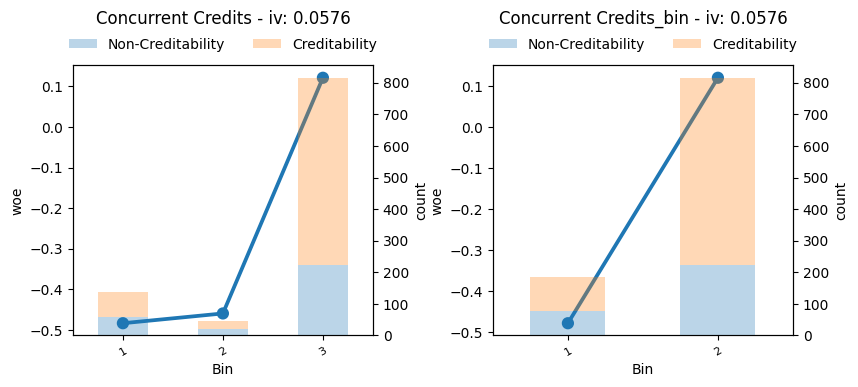

In [23]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_table, _ = woe_iv_calc(german_credit_ds, 'Concurrent Credits', 'Creditability', plot=True, as_subplot=True)
mapping = {1:1, 2:1, 3:2}
german_credit_ds['Concurrent Credits_bin'] = german_credit_ds['Concurrent Credits'].map(mapping)
plt.subplot(1,2,2)
plot_table, concurrent_credit_woe_mapping = woe_iv_calc(german_credit_ds, 'Concurrent Credits_bin', 'Creditability', plot=True, as_subplot=True)
plt.subplots_adjust(left=0.1,
                            bottom=0.05,
                            right=0.9,
                            top=0.95,
                            wspace=0.4,
                            hspace=0.4)
plt.show()

* Installment percentage
    * We will use the current grouping. The higher the installment percentage of income the higher the woe value meaning that the borrower is capable to manage the credit with the higher debt service.

Information Value for the Feature is: 0.026322090054334526


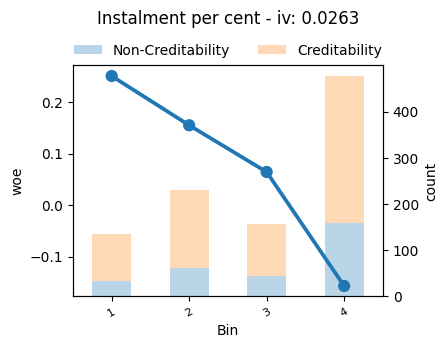

In [24]:
plot_table, installment_woe_mapping = woe_iv_calc(german_credit_ds, 'Instalment per cent', 'Creditability', plot=True)

In [25]:
# Remaining features after fine-tuning the binning
drop_columns_list = ['Concurrent Credits', 'Payment Status of Previous Credit', 'Duration of Credit (month)', 'Purpose_bin', 'Purpose', 'Credit Amount',
'Credit Amount_bin', 'Sex & Marital Status', 'Age (years)', 'age_bin', 'Length of current employment', 'Type of apartment', 'Most valuable available asset', 
'Guarantors', 'Duration in Current address', 'No of Credits at this Bank', 'Occupation', 'No of dependents', 'Telephone']
ds_analysis = german_credit_ds.drop(columns = drop_columns_list)
ds_analysis.columns

Index(['Creditability', 'Account Balance', 'Value Savings/Stocks',
       'Instalment per cent', 'Foreign Worker',
       'Most valuable available asset_bin', 'Type of apartment_bin',
       'Length of current employment_bin', 'age_bin2',
       'Sex & Marital Status_bin', 'Credit Amount_bin2', 'Purpose_bin2',
       'Duration of Credit (month)_bin',
       'Payment Status of Previous Credit_bin', 'Concurrent Credits_bin'],
      dtype='object')

Make the WOE transformation for all the features.

In [26]:
ds_analysis['account_balance_woe'] = ds_analysis['Account Balance'].map(account_balance_woe_mapping)
ds_analysis['value_saving_woe'] = ds_analysis['Value Savings/Stocks'].map(value_savings_woe_mapping)
ds_analysis['installment_woe'] = ds_analysis['Instalment per cent'].map(installment_woe_mapping)
ds_analysis['foreign_worker_woe'] = ds_analysis['Foreign Worker'].map(foreign_worker_woe_mapping)
ds_analysis['most_valuable_assets_woe'] = ds_analysis['Most valuable available asset_bin'].map(valuable_asset_woe_mapping)
ds_analysis['apartment_woe'] = ds_analysis['Type of apartment_bin'].map(apartment_woe_mapping)
ds_analysis['length_employment_woe'] = ds_analysis['Length of current employment_bin'].map(length_employment_woe_mapping)
ds_analysis['age_woe'] = ds_analysis['age_bin2'].map(age_woe_mapping)
ds_analysis['sex_marital_woe'] = ds_analysis['Sex & Marital Status_bin'].map(sex_marital_woe_mapping)
ds_analysis['credit_amount_woe'] = ds_analysis['Credit Amount_bin2'].map(credit_amount_woe_mapping)
ds_analysis['purpose_woe'] = ds_analysis['Purpose_bin2'].map(purpose_woe_mapping)
ds_analysis['duration_credit_woe'] = ds_analysis['Duration of Credit (month)_bin'].map(duration_credit_woe_mapping)
ds_analysis['payment_status_woe'] = ds_analysis['Payment Status of Previous Credit_bin'].map(payment_status_woe_mapping)
ds_analysis['concurrent_credit_woe'] = ds_analysis['Concurrent Credits_bin'].map(concurrent_credit_woe_mapping)

Select the WOE features for next steps.

In [27]:
drop_column_list2 = ['Account Balance', 'Value Savings/Stocks',
       'Instalment per cent', 'Foreign Worker',
       'Most valuable available asset_bin', 'Type of apartment_bin',
       'Length of current employment_bin', 'age_bin2',
       'Sex & Marital Status_bin', 'Credit Amount_bin2', 'Purpose_bin2',
       'Duration of Credit (month)_bin',
       'Payment Status of Previous Credit_bin', 'Concurrent Credits_bin']
ds_analysis_woe = ds_analysis.drop(columns = drop_column_list2)
ds_analysis_woe.columns

Index(['Creditability', 'account_balance_woe', 'value_saving_woe',
       'installment_woe', 'foreign_worker_woe', 'most_valuable_assets_woe',
       'apartment_woe', 'length_employment_woe', 'age_woe', 'sex_marital_woe',
       'credit_amount_woe', 'purpose_woe', 'duration_credit_woe',
       'payment_status_woe', 'concurrent_credit_woe'],
      dtype='object')

In [28]:
ds_analysis_woe.describe()

,Creditability,account_balance_woe,value_saving_woe,installment_woe,foreign_worker_woe,most_valuable_assets_woe,apartment_woe,length_employment_woe,sex_marital_woe,purpose_woe,payment_status_woe,concurrent_credit_woe
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,0.156859,0.048089,0.005349,0.013151,0.021774,0.015284,0.016457,0.008403,0.033219,0.050851,0.009815
std,0.458487,0.870845,0.473730,0.163103,0.245094,0.336229,0.285761,0.291147,0.208866,0.401703,0.543844,0.233086
min,0.000000,-0.818099,-0.271358,-0.157300,-0.034867,-0.586082,-0.436002,-0.431137,-0.441833,-0.461635,-1.234071,-0.477551
25%,0.000000,-0.818099,-0.271358,-0.157300,-0.034867,-0.031882,-0.436002,-0.032103,-0.235341,-0.359200,-0.087869,0.121179
50%,1.000000,-0.401392,-0.271358,0.064539,-0.034867,-0.031882,0.196052,-0.032103,0.161641,-0.095557,-0.087869,0.121179
75%,1.000000,1.176263,0.704246,0.155466,-0.034867,0.461035,0.196052,0.235566,0.161641,0.410063,0.733741,0.121179
max,1.000000,1.176263,1.098612,0.251314,1.262915,0.461035,0.196052,0.394415,0.161641,0.773836,0.733741,0.121179


### 3.2 Multivariate Analysis - Multicolinearity Evaluation

In this section, we will evaluate the multicolinearity among the features within each risk categories. Since the purpose is to have stable coefficient estimation, we will eliminate the variables with less predictive power but add multi-colinearity.

In [29]:
ds_analysis_woe.drop(columns='Creditability').corr()

,account_balance_woe,value_saving_woe,installment_woe,foreign_worker_woe,most_valuable_assets_woe,apartment_woe,length_employment_woe,sex_marital_woe,purpose_woe,payment_status_woe,concurrent_credit_woe
account_balance_woe,1.000000,0.227139,0.000531,-0.028890,0.067630,0.122286,0.110676,0.055155,0.126356,0.196636,0.064943
value_saving_woe,0.227139,1.000000,-0.032864,0.002572,-0.006553,0.013581,0.102940,0.021062,0.066350,0.046966,0.002873
installment_woe,0.000531,-0.032864,1.000000,0.096692,0.043980,-0.049963,-0.073242,-0.122058,0.000742,-0.037194,0.001565
foreign_worker_woe,-0.028890,0.002572,0.096692,1.000000,0.098868,-0.004900,-0.035311,0.078196,-0.085559,0.036576,0.012008
most_valuable_assets_woe,0.067630,-0.006553,0.043980,0.098868,1.000000,0.360856,-0.043934,-0.075798,0.001321,0.074893,0.102606
apartment_woe,0.122286,0.013581,-0.049963,-0.004900,0.360856,1.000000,0.028854,0.072730,-0.005128,0.100731,-0.035238
length_employment_woe,0.110676,0.102940,-0.073242,-0.035311,-0.043934,0.028854,1.000000,0.197490,0.066396,0.112586,0.023612
sex_marital_woe,0.055155,0.021062,-0.122058,0.078196,-0.075798,0.072730,0.197490,1.000000,0.077791,0.044123,-0.052177
purpose_woe,0.126356,0.066350,0.000742,-0.085559,0.001321,-0.005128,0.066396,0.077791,1.000000,0.046871,0.052979
payment_status_woe,0.196636,0.046966,-0.037194,0.036576,0.074893,0.100731,0.112586,0.044123,0.046871,1.000000,0.249222


Using variance inflation factor (VIF) to evaluate if there's any multi-colinearity.

In [30]:
X_df = ds_analysis_woe.drop(columns='Creditability')
X = add_constant(X_df)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                       1.062745
account_balance_woe         1.143231
value_saving_woe            1.071228
installment_woe             1.058572
foreign_worker_woe          1.067131
most_valuable_assets_woe    1.307272
apartment_woe               1.212561
length_employment_woe       1.104425
age_woe                     1.138304
sex_marital_woe             1.109474
credit_amount_woe           1.081336
purpose_woe                 1.048333
duration_credit_woe         1.184060
payment_status_woe          1.144076
concurrent_credit_woe       1.095812
dtype: float64

## 4. Modeling and Evaluation- Logistic Regression

In this section we will use logistic regression, tune the hyper-parameters and get the final binary classification model. Since we have transform the data to be woe based, we don't need to do standardization.

In [31]:
# Split training and testing
X_orig, y = ds_analysis_woe.iloc[:,1:], ds_analysis_woe.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.3, random_state=0)

In [32]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Defined the parameters
## The solver to be used for estimating coefficients
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
## Penalty term to be used
penalty = ['l2']
## Inverse of egularization strength, the larger the less stringent
c = [100, 10, 1.0, 0.3, 0.1, 0.01, 0.001]
## maximum iteration taken for algorithms to converge
max_iter = [10000]

# Combine all parameters
params = {'solver': solver, 'penalty': penalty, 'C': c, 'max_iter': max_iter}


# Create the logistic regression model
clf = LogisticRegression()

# Cross validation generator
cv_repeat = RepeatedStratifiedKFold(n_splits = 5, n_repeats=3, random_state = 0)

# Grid Search the best parameter for the solver and c
grid_search = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, cv=cv_repeat, scoring='roc_auc')
grid_search_result = grid_search.fit(X_train, y_train)

# Output results
print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
# Fit the final model
best_param = grid_search_result.best_params_
final_logit_model = LogisticRegression(solver=best_param['solver'], penalty='l2', C=best_param['C'], max_iter=10000, random_state=0 )
final_logit_model.fit(X_train, y_train)
y_train_pred = final_logit_model.predict_proba(X_train)
y_test_pred = final_logit_model.predict_proba(X_test)
print(f'Trainig AUC Score: {roc_auc_score(y_train, y_train_pred[:, 1])}')
print(f'Trainig Accuracy: {accuracy_score(y_train, final_logit_model.predict(X_train))}')
print(f'Test AUC Score: {roc_auc_score(y_test, y_test_pred[:, 1])}')
print(f'Testing Accuracy: {accuracy_score(y_test, final_logit_model.predict(X_test))}')

Best: 0.813950 using {'C': 1.0, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Trainig AUC Score: 0.8324800000000001
Trainig Accuracy: 0.7842857142857143
Test AUC Score: 0.8425499999999999
Testing Accuracy: 0.7766666666666666


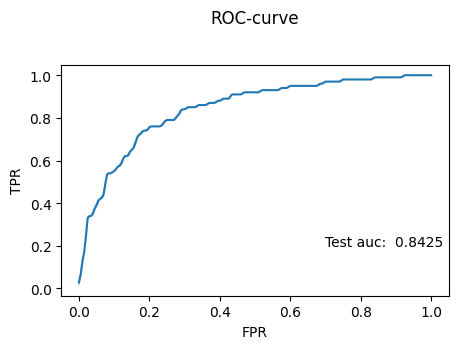

In [33]:
# Mannually calculate the test auc
actual_pred = pd.DataFrame({'y': y_test.values, 'prob_good': y_test_pred[:, 1], 'count':np.ones(len(y_test.values))})
pdf = pd.pivot_table(data=actual_pred, index='prob_good', columns='y', values='count', aggfunc = 'count', fill_value=0)
pdf = pdf.divide(pdf.sum(axis=0))
cdf = pdf.cumsum()
fig, ax = plt.subplots(figsize=(5, 3))
ax = sns.lineplot(data=cdf, x=1, y=0)
ax.set(title='ROC-curve', xlabel='FPR', ylabel='TPR')
# Calculate area under the ROC-curve
auc = ((1 - cdf[1] - pdf[1]/2) * pdf[0]).sum()
if auc < 0.5:
    auc = 1 - auc
ax.annotate(f'Test auc: {auc: .4f}', xy=(0.7, 0.2), xytext=(0.7, 0.2))
plt.show()

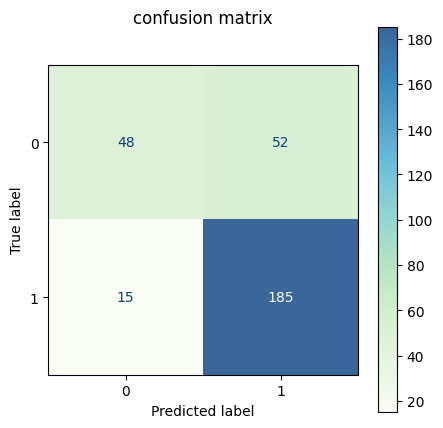

In [34]:
perfc.plot_confusion_matrix(final_logit_model, X_test, y_test)

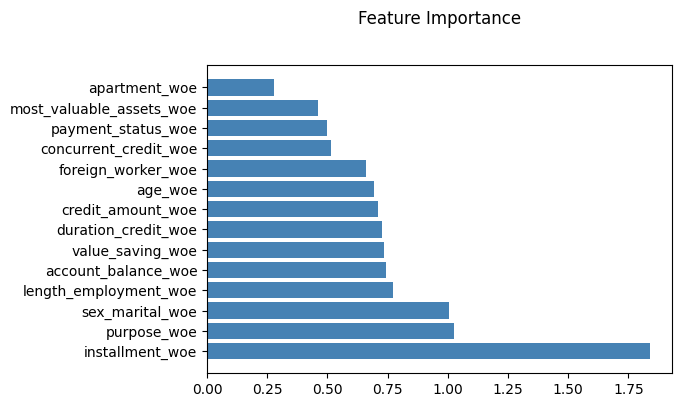

In [35]:
ogit_fi_df = perfc.plot_feature_importance(final_logit_model, ds_analysis_woe.columns[1:], None, figsize=(6, 4))

## 5. Scaling to Generate Credit Scores

In this section we will get the factor and offset to generate credit scores assuming that
* We want creditability to non-creditability odds 50:1 at 640 score
* We want score to increase 20 when odds doubled.
$$ \text{Score} = \text{Offset} + \text{Factor} \times \log (\text{odds})$$
$$\text{Score} + pdo = \text{Offset} + \text{Factor} \times \log (2 \cdot \text{odds})$$
$$\rightarrow \text{Factor} = pdo / \log(2), \text{Offset} = \text{Score} - (\text{Factor} \times \log(\text{Odds}))$$
$$ \text{Factor} = pdo / \log(2) = 28.85,  \text{Offset} = 640 - (28.85 \times \log(50)) = 527.12$$

In [36]:
def calc_factor_offset(anchor_odds, anchor_score, pdo):
    factor = pdo / np.log(2)
    offset = anchor_score - factor * np.log(anchor_odds)
    return factor, offset

factor, offset = calc_factor_offset(50, 640, 20)
print(f"factor: {factor}")
print(f"offset: {offset}")

factor: 28.85390081777927
offset: 527.1228762045055


In [37]:
def scale_score(X_woe, logit_model, factor, offset): 
    pred_prob = logit_model.predict_proba(X_woe)[:, 1]
    log_odds = np.log(pred_prob/(1 - pred_prob))
    score = offset + factor * log_odds
    return X_woe.assign(score=score, pred_prob=pred_prob)

X_test_score = scale_score(X_test, final_logit_model, factor, offset)
X_test_score.head()

,account_balance_woe,value_saving_woe,installment_woe,foreign_worker_woe,most_valuable_assets_woe,apartment_woe,length_employment_woe,age_woe,sex_marital_woe,credit_amount_woe,purpose_woe,duration_credit_woe,payment_status_woe,concurrent_credit_woe,score,pred_prob
993,-0.818099,-0.271358,0.251314,-0.034867,0.461035,-0.436002,0.235566,-0.064539,-0.235341,-0.342203,-0.359200,-0.096228,0.733741,-0.477551,527.244502,0.501054
859,-0.818099,-0.139552,-0.157300,-0.034867,-0.586082,0.196052,-0.431137,-0.064539,0.161641,-0.140357,0.410063,0.267315,-0.087869,0.121179,527.718144,0.505157
298,-0.401392,1.098612,0.251314,-0.034867,0.461035,-0.436002,-0.431137,-0.528844,-0.235341,-0.026317,-0.095557,0.267315,-0.087869,0.121179,559.993554,0.757535
553,1.176263,0.704246,-0.157300,-0.034867,-0.031882,0.196052,0.394415,0.314115,-0.235341,-0.140357,-0.179468,0.553595,-0.087869,0.121179,598.690771,0.922753
672,-0.401392,-0.271358,-0.157300,-0.034867,0.461035,0.196052,-0.032103,-0.064539,-0.235341,-0.026317,0.410063,-0.096228,-0.087869,0.121179,539.923954,0.609129


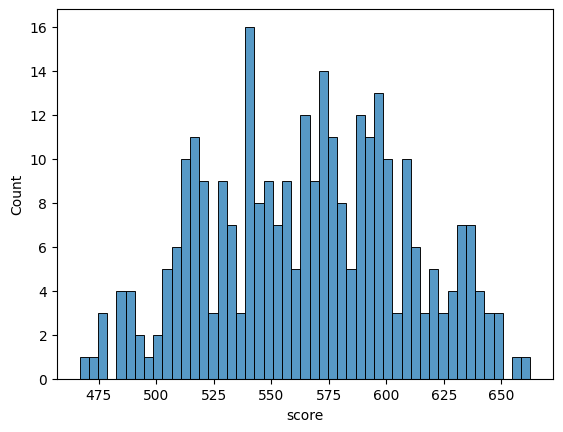

In [38]:
sns.histplot(data=X_test_score, x='score', binwidth=4)
plt.show()